In [ ]:
# Brownian v2 and v3 in this file. v2 is just for archival purpose. Use v3 for multiprocessing.

In [198]:
import random, matplotlib.pyplot as plt, time, math, multiprocessing, concurrent.futures
import numpy as np

from itertools import repeat


#plt.style.use(['science'])

def flatten(xss):
    return [x for xs in xss for x in xs]

gamma,Radius_of_circle=1,1
sigma,drift,potential_constant,time2=0.7,0.1,1,10

ram0=10
def brownian_v5(iterations):

    #pos=np.zeros((iterations,ram0))
    #cur=np.zeros((iterations,ram0))

    C=[sigma, drift, potential_constant, iterations,time2]
    
    intial_pos=-np.arcsin(-Radius_of_circle*drift/potential_constant)+np.pi

    theta0=np.full(ram0,intial_pos) 
    #use above theta0 for f<V0. For f>V0, use below theta0
    #theta0=np.full(ram0,np.pi/2) 
    
    theta=np.full(ram0,theta0)
    theta2=np.zeros(ram0)
    
    dt=0.1 
    T=int(time2/dt)                                #Total time of iteration which needs breaking down for more data points
    std=np.sqrt(dt*sigma)
    
    prefactor=1/(gamma*Radius_of_circle)
    
    Delta=10
    tau=100
    l=100
    
    cur2=[[] for i in repeat(None, int((T-l)/Delta))]
    for n in range(iterations):
        
        theta=np.full(ram0,theta0)
        temp = np.zeros((T,ram0))
        
        for i in range(T):
            
            theta+=prefactor*(np.random.normal(0,std, ram0)+(drift-potential_constant*(-np.sin(theta))/Radius_of_circle)*dt)
            temp[i] = theta
            
        #theta2=theta-np.floor((theta-np.pi)/(2*np.pi))*2*np.pi-2*np.pi
        
        for j in range(int((T-l)/Delta)):
            I=l+j*Delta
            
            for k in range(int((T-l-j*Delta)/tau)):
                tempslice=temp[k*tau+I]-temp[k*tau]

                #tempslice=tempslice.flatten.tolist()     why is tempslice not np array??
                
                #print(cur2)
                
                cur2[j].extend(Radius_of_circle*tempslice/(I*dt))
        
        
        #pos[n]=theta2
        #cur[n]=Radius_of_circle*(theta-theta0)/time2
        
        

    #pos=pos.flatten()
    #cur=cur.flatten()


    return cur2    #pos,cur #D

if __name__ == "__main__":
    iterations=10**2
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        start_time = time.perf_counter()
        temp = list(executor.map(brownian_v5, [10 for i in range(int(iterations/10))]))
        finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
    

results = [[temp[i][j] for i in range(len(temp))] for j in range(len(temp[0]))]
cur = flatten(results[1])

print(len(cur))


Program finished in 0.49318546199356206 seconds
46000


In [68]:
import random, matplotlib.pyplot as plt, time, math, multiprocessing, concurrent.futures
import numpy as np

gamma,Radius_of_circle=1,1
sigma,drift,potential_constant,time2=0.8,0.3,1,20

num_points_k,N=100,20
start_k=-1
end_k=1

num_points_j=100
start_j=-0.75
end_j=1.3

def scgf(sigma,drift,potential_constant):
    lamx=[]
    lamy=[]
    for i in range(num_points_k):
        k=start_k+(end_k-start_k)/num_points_k*i
        
        mat=np.zeros((2*N+1+2,2*N+1+2), dtype=complex)
        
        for i in range(1,len(mat)-1):
            mat[i,i]=(drift+k*sigma**2)*(-N+i-1)*1j-sigma**2*(-N+i-1)**2/2+k*drift+k**2*sigma**2/2
            mat[i,i-1]=potential_constant/2*(-N+i-1-1-k*1j)
            mat[i,i+1]=potential_constant/2*(N-i+1-1+k*1j)
        
        a=np.linalg.eigvals(mat[1:-1,1:-1])
        b=[]
        for i in range(len(a)):
            if abs(a[i].imag)<1e-7:
                b.append(a[i].real)
        
        lamx.append(k)
        lamy.append(b[0])
    
    return [lamx,lamy]

def ratefn(sigma,drift,potential_constant):
    Ix=[]
    Iy=[]
    for i in range(num_points_j):
        j=start_j+(end_j-start_j)/num_points_j*i
        
        Ix.append(j)
        Iy.append(max(np.array(scgf(sigma,drift,potential_constant)[0])*j-scgf(sigma,drift,potential_constant)[1]))
        
    return [Ix,Iy]




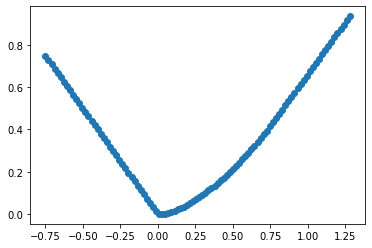

In [69]:
arr=ratefn(sigma,drift,potential_constant)
plt.scatter(arr[0],arr[1])

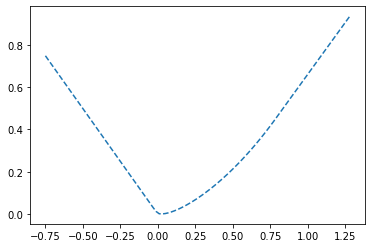

In [74]:
from scipy import interpolate

tck = interpolate.splrep(arr[0], arr[1], s=0)
xnew = np.arange(start_j, end_j, (end_j-start_j)/num_points_j)
ynew = interpolate.splev(xnew, tck, der=0)

plt.figure()
plt.plot(xnew, ynew,'--')

plt.show()

0.020337268000048425


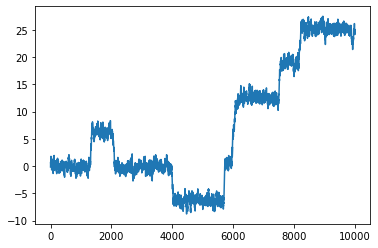

In [8]:
def brownian(sigma,drift,potential_constant,iterations,time):
    #gamma=1.380649*(10**(-23))*300/diffusion
    A=[] #Set of final positions
    B=[]
    C=[sigma, drift, potential_constant, iterations,time]
    theta0=-np.arcsin(-Radius_of_circle*drift/potential_constant)+np.pi 
    theta1=np.arcsin(-Radius_of_circle*drift/potential_constant)
    #use above theta0 for f<V0. For f>V0, use below theta0
    #theta0=-0.5
    theta=theta0
    
    
    K2=[]
    
    theta2=0
    dt=0.1 #time increment
    T=int(time/dt) #Total time
    std=np.sqrt(dt*sigma)
    prefactor=1/(gamma*Radius_of_circle)
    for n in range(iterations):
        D=[]
        K=[]
        K0=0
        for i in range(T):
            theta+=prefactor*(random.gauss(0,std)+(drift-potential_constant*(-np.sin(theta))/Radius_of_circle)*dt)
            D.append(theta-theta0)
            #if theta0-(theta0+theta1+np.pi)/2<theta<theta1+(theta0+theta1+np.pi)/2:
            #    K0=theta
            #    K.append(K0)
            #else:
            #    break
        theta2=theta-np.floor((theta-np.pi)/(2*np.pi))*2*np.pi-2*np.pi
            
        A.append(theta2)
        B.append(Radius_of_circle*(theta-theta0)/time)
        K2.append(K)
        
        
        theta=theta0
    K2=flatten(K2)

    return A,B,C,D,K2

t1=time.perf_counter()
data=brownian(0.7,0.1,1,10**0,1000)
print(time.perf_counter()-t1)

xs = [x for x in range(len(data[3]))]

plt.plot(xs, data[3])
plt.show()

In [76]:
import random, matplotlib.pyplot as plt, time, math, multiprocessing, concurrent.futures
import numpy as np

from itertools import repeat


#plt.style.use(['science'])

def flatten(xss):
    return [x for xs in xss for x in xs]

gamma,Radius_of_circle=1,1
sigma,drift,potential_constant,time2=0.8,0.3,1,1000

Delta,tau,l=10,100,100

dt=0.1
T=int(time2/dt)                                #Total time of iteration which needs breaking down for more data points


ram0=128
def brownian_v4(iterations):

    C=[sigma, drift, potential_constant, iterations,time2]
    
    intial_pos=-np.arcsin(-Radius_of_circle*drift/potential_constant)+np.pi

    theta0=np.full(ram0,intial_pos) 
    #use above theta0 for f<V0. For f>V0, use below theta0
    #theta0=np.full(ram0,np.pi/2) 
    
    theta=np.full(ram0,theta0)
    theta2=np.zeros(ram0)
    
     
    
    std=np.sqrt(dt*sigma)
    
    prefactor=1/(gamma*Radius_of_circle)
    
    cur2=[[] for i in repeat(None, int((T-l)/Delta))]
    for n in range(iterations):
        
        theta=np.full(ram0,theta0)
        temp = np.zeros((T,ram0))
        
        for i in range(T):
            
            theta+=prefactor*(np.random.normal(0,std, ram0)+(drift-potential_constant*(-np.sin(theta))/Radius_of_circle)*dt)
            temp[i] = theta
            
        #theta2=theta-np.floor((theta-np.pi)/(2*np.pi))*2*np.pi-2*np.pi
        
        for j in range(int((T-l)/Delta)):
            I=l+j*Delta
            
            for k in range(int((T-l-j*Delta)/tau)):
                tempslice=temp[k*tau+I]-temp[k*tau]
                
                cur2[j].extend(Radius_of_circle*tempslice/(I*dt))

    return cur2    

In [ ]:
t1=time.perf_counter()
info=brownian_v4(10**2)
print(time.perf_counter()-t1)

len(info)

<function matplotlib.pyplot.show(close=None, block=None)>

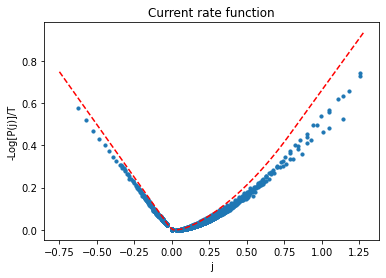

In [75]:
xvals=[]
yvals=[]

for j in range(0,200,1):
    cur=info[j]
    I=l+j*Delta
    
    bins_manual=[]
    for i in range(-15,30):
        bins_manual.append((2*np.pi*i-np.pi)/(I*dt))

    pj=np.histogram(cur, bins=bins_manual, density=True)[0]
    pjx=np.histogram(cur, bins=bins_manual, density=True)[1]
    pjj=[]
    pjjx=[]
    for i in range(len(pj)-1):
        if pj[i]!=0:
            pjj.append(pj[i])
            pjjx.append((pjx[i+1]+pjx[i])/2)
    pj2=(-1/(I*dt))*np.log(pjj)
    
    xvals.extend(pjjx)
    #xvals.extend(pjjx-(pjjx[np.argmin(pj2)]-arr[0][np.argmin(arr[1])]))
    yvals.extend(pj2-min(pj2))

plt.scatter(xvals,yvals,s=10)
plt.title('Current rate function')
plt.xlabel('j')
plt.ylabel('-Log[P(j)]/T')

plt.plot(xnew, ynew,'r--')

plt.show

In [91]:
arr[0][np.argmin(arr[1])]

0.025000000000000133

In [ ]:
j=5
cur=info[j]

I=l+j*Delta

bins_manual=[]
for i in range(-15,30):
    bins_manual.append((2*np.pi*i-np.pi)/(I*dt))
    
pj=np.histogram(cur, bins=bins_manual, density=True)[0]
pjx=np.histogram(cur, bins=bins_manual, density=True)[1]
pjj=[]
pjjx=[]
for i in range(len(pj)-1):
    if pj[i]!=0:
        pjj.append(pj[i])
        pjjx.append((pjx[i+1]+pjx[i])/2)
pj2=(-1/(I*dt))*np.log(pjj)

Area=np.sum(pj)*(pjx[2]-pjx[1])
    
#Don't divide by area or area2. Useless


pj2=(-1/(I*dt))*np.log(pjj)


plt.scatter(pjjx,pj2)
plt.title('Current rate function')
plt.xlabel('j')
plt.ylabel('-Log[P(j)]/T')

plt.show

In [46]:
xvals

[-0.17135959928671599,
 -0.11423973285781067,
 -0.057119866428905326,
 0.0,
 0.057119866428905326,
 0.11423973285781067,
 0.17135959928671599,
 0.22847946571562133,
 0.2855993321445266,
 -0.17135959928671599,
 -0.11423973285781067,
 -0.057119866428905326,
 0.0,
 0.057119866428905326,
 0.11423973285781067,
 0.17135959928671599,
 0.22847946571562133,
 0.2855993321445266,
 -0.17135959928671599,
 -0.11423973285781067,
 -0.057119866428905326,
 0.0,
 0.057119866428905326,
 0.11423973285781067,
 0.17135959928671599,
 0.22847946571562133,
 0.2855993321445266,
 -0.17135959928671599,
 -0.11423973285781067,
 -0.057119866428905326,
 0.0,
 0.057119866428905326,
 0.11423973285781067,
 0.17135959928671599,
 0.22847946571562133,
 0.2855993321445266,
 -0.17135959928671599,
 -0.11423973285781067,
 -0.057119866428905326,
 0.0,
 0.057119866428905326,
 0.11423973285781067,
 0.17135959928671599,
 0.22847946571562133,
 0.2855993321445266,
 -0.17135959928671599,
 -0.11423973285781067,
 -0.057119866428905326,


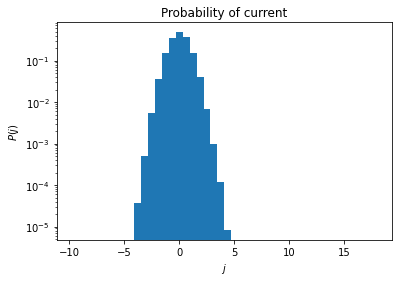

In [19]:
bins_manual=[]
for i in range(-15,30):
    bins_manual.append((2*np.pi*i-np.pi)/time2)   #data[2][4] is time

fig2 = plt.figure(2)
#plt.hist(cur, bins=5000, density=True)
plt.hist(cur, bins=bins_manual,density=True)
plt.title('Probability of current')
plt.xlabel('$j$')
plt.ylabel('$P(j)$')
plt.yscale('log')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

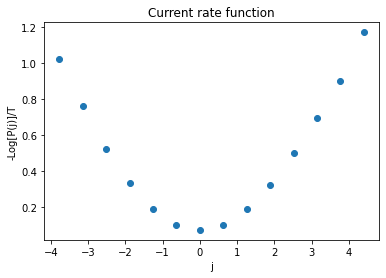

In [36]:
bins_manual=[]
for i in range(-15,30):
    bins_manual.append((2*np.pi*i-np.pi)/time2)
    
pj=np.histogram(cur, bins=bins_manual, density=True)[0]
pjx=np.histogram(cur, bins=bins_manual, density=True)[1]
pjj=[]
pjjx=[]
for i in range(len(pj)-1):
    if pj[i]!=0:
        pjj.append(pj[i])
        pjjx.append((pjx[i+1]+pjx[i])/2)
pj2=(-1/time2)*np.log(pjj)

Area=np.sum(pj)*(pjx[2]-pjx[1])
    
#Don't divide by area or area2. Useless


pj2=(-1/time2)*np.log(pjj)


plt.scatter(pjjx,pj2)
plt.title('Current rate function')
plt.xlabel('j')
plt.ylabel('-Log[P(j)]/T')

plt.show

In [160]:
Area

1.000000000000001

<function matplotlib.pyplot.show(close=None, block=None)>

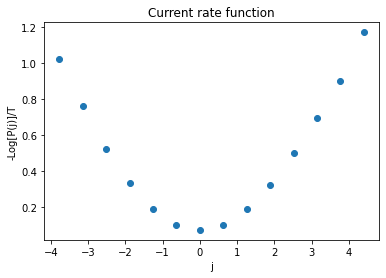

In [21]:
plt.scatter(pjjx,pj2)
plt.title('Current rate function')
plt.xlabel('j')
plt.ylabel('-Log[P(j)]/T')

plt.show

In [35]:
pjjx

[-0.15707963267948966,
 -0.07853981633974483,
 0.0,
 0.07853981633974483,
 0.15707963267948966,
 0.23561944901923448]

In [210]:
min(cur)

-0.02510343640535555

In [55]:
import numpy as np
import random, matplotlib.pyplot as plt, time, math

gamma,Radius_of_circle=1,1

ram0=1024

def brownian_v2(sigma,drift,potential_constant,iterations,time):
    #gamma=1.380649*(10**(-23))*300/diffusion
    pos=np.zeros((iterations,ram0))
    cur=np.zeros((iterations,ram0))
    A=np.zeros(ram0)
    B=np.zeros(ram0)
    C=[sigma, drift, potential_constant, iterations,time]
    intial_pos=-np.arcsin(-Radius_of_circle*drift/potential_constant)+np.pi
    theta0=np.full(ram0,intial_pos) 
    #use above theta0 for f<V0. For f>V0, use below theta0
    #theta0=np.pi/2
    theta=np.full(ram0,theta0)
    theta2=np.zeros(ram0)
    dt=0.1 #time increment
    T=int(time/dt) #Total time
    std=np.sqrt(dt*sigma)
    prefactor=1/(gamma*Radius_of_circle)
    for n in range(iterations):
        #D=np.zeros(T)
        #D[0]=intial_pos
        
        for i in range(T):
            #D[i]=theta[0]-theta0[0]
            theta+=prefactor*(np.random.normal(0,std, ram0)+(drift-potential_constant*(np.sin(theta))/Radius_of_circle)*dt)
            
        for k in range(len(theta)):
            if -np.pi<theta[k]<=np.pi:
                theta2[k]=theta[k]
            else:
                theta2[k]=-np.sign(theta[k])*np.pi+theta[k]-np.pi-int((theta[k]-np.pi)/(2*np.pi))*2*np.pi   
        pos[n]=theta2
        cur[n]=Radius_of_circle*(theta-theta0)/time
        
        theta=np.full(ram0,theta0)

    pos=pos.flatten()
    cur=cur.flatten()
    
    return pos,cur,C,#D

In [104]:
t1=time.perf_counter()
data=brownian_v2(0.3,0.1,1,256,3)
print(time.perf_counter()-t1)

0.5873084320046473


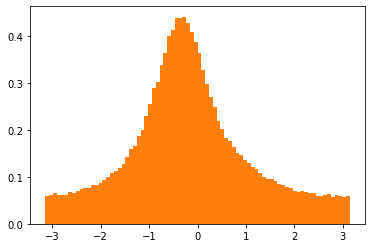

In [105]:
qj=plt.hist(data[0], bins=80, density=True)[0]
qjx=plt.hist(data[0], bins=80, density=True)[1]
qjj=[]
qjjx=[]
for i in range(len(qj)-1):
    if qj[i]!=0:
        qjj.append(qj[i])
        qjjx.append((qjx[i+1]+qjx[i])/2
qj2=(-1e-1)*np.log(qjj)

<function matplotlib.pyplot.show(close=None, block=None)>

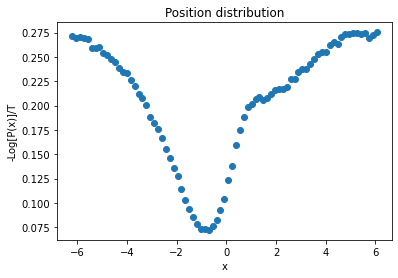

In [101]:
jupyter nbextension enable codefolding/mainplt.scatter(qjjx,qj2)
plt.title('Position distribution')
plt.xlabel('x')
plt.ylabel('-Log[P(x)]/T')

plt.show

In [25]:
min(cur)

-0.23849806549897842

In [9]:
print(len(bins_manual))

20


In [58]:
-np.arcsin(-Radius_of_circle*0.1/1)+np.pi

3.241760074751353

In [2]:
pj=plt.hist(cur, bins=bins_manual, density=True)[0]

NameError: name 'plt' is not defined

In [3]:
import random, matplotlib.pyplot as plt, time, math, multiprocessing, concurrent.futures
import numpy as np

from itertools import repeat


#plt.style.use(['science'])

def flatten(xss):
    return [x for xs in xss for x in xs]

gamma,Radius_of_circle=1,1
sigma,drift,potential_constant,time2=0.9,0.1,1,10

ram0=128
def brownian_v4(iterations):

    #pos=np.zeros((iterations,ram0))
    #cur=np.zeros((iterations,ram0))

    C=[sigma, drift, potential_constant, iterations,time2]
    
    intial_pos=-np.arcsin(-Radius_of_circle*drift/potential_constant)+np.pi

    theta0=np.full(ram0,intial_pos) 
    #use above theta0 for f<V0. For f>V0, use below theta0
    #theta0=np.full(ram0,np.pi/2) 
    
    theta=np.full(ram0,theta0)
    theta2=np.zeros(ram0)
    
    dt=0.1 
    T=int(time2/dt)                                #Total time of iteration which needs breaking down for more data points
    std=np.sqrt(dt*sigma)
    
    prefactor=1/(gamma*Radius_of_circle)
    
    Delta=1
    tau=2
    l=5
    
    cur2=[[] for i in repeat(None, int((T-l)/Delta))]
    for n in range(iterations):
        
        theta=np.full(ram0,theta0)
        temp = np.zeros((T,ram0))
        
        for i in range(T):
            
            theta+=prefactor*(np.random.normal(0,std, ram0)+(drift-potential_constant*(-np.sin(theta))/Radius_of_circle)*dt)
            temp[i] = theta
            
        #theta2=theta-np.floor((theta-np.pi)/(2*np.pi))*2*np.pi-2*np.pi
        
        for j in range(int((T-l)/Delta)):
            I=l+j*Delta
            
            for k in range(int((T-l-j*Delta)/tau)):
                tempslice=temp[k*tau+I]-temp[k*tau]

                #tempslice=tempslice.flatten.tolist()     why is tempslice not np array??
                
                #print(cur2)
                
                cur2[j].extend(Radius_of_circle*tempslice/(I*dt))
        
        
        #pos[n]=theta2
        #cur[n]=Radius_of_circle*(theta-theta0)/time2
        
        

    #pos=pos.flatten()
    #cur=cur.flatten()


    return cur2    #pos,cur #D

In [4]:
info=brownian_v4(10**2)

In [6]:
len(info[93])

12800

(array([2.79997713e-04, 3.31378737e-03, 4.13963629e-02, 2.53877102e-01,
        5.94807513e-01, 4.89288787e-01, 1.46704369e-01, 2.00328261e-02,
        1.93977797e-03, 1.81854185e-04]),
 array([-3.09371892, -2.44931527, -1.80491162, -1.16050798, -0.51610433,
         0.12829932,  0.77270297,  1.41710661,  2.06151026,  2.70591391,
         3.35031756]),
 <BarContainer object of 10 artists>)

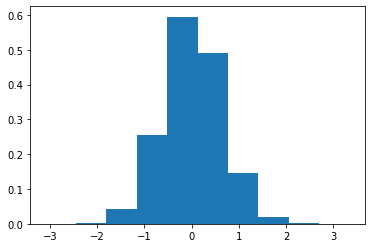

In [225]:
plt.hist(info[10], bins=10, density=True)

In [40]:
del2=[[] for i in repeat(None, 10)]

del2[1].append([1,-2,4])

del2

[[], [[1, -2, 4]], [], [], [], [], [], [], [], []]